In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ["CUDA_VISIBLE_DEVICES"]= '5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import tensorly as tl
import tensorly.backend as T
from tensorly.decomposition import tucker
from tensorly.base import unfold, fold
from tensorly.tenalg import multi_mode_dot, mode_dot
tl.set_backend('pytorch')

import random

from tqdm import tqdm
import itertools
from time import time
import logging
import warnings

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from IPython import display
params = {'text.usetex' : False,

          'font.size' : 16,
          }
plt.rcParams.update(params)
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def nrmse(y_pred, y_true):
    """ Normalized RMSE"""
    t1 = np.linalg.norm(y_pred - y_true)**2 / np.size(y_true)
    t2 = np.sum(abs(y_true)) / np.size(y_true)
    return np.sqrt(t1) / t2

In [4]:
def make_deterministic(seed=42):    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
make_deterministic()

In [5]:
def nunfold(tensor,n):
    """
    Unfolding function.
    """
    size = np.array(tensor.shape)
    N = size.shape[0]
    I = int(size[n])
    J = int(int(np.prod(size)) / int(I))
    pmt=list(range(n,n+1))
    pmt=pmt + list(range(0,n))
    pmt=pmt + list(range(n+1,N))
    return torch.reshape(torch.permute(torch.tensor(tensor), pmt),[I, J])

def nfold(matrix,n,size_t_ori):
    """
    Folding function.
    """
    N = np.array(size_t_ori).shape[0]
    size_t_pmt = np.concatenate([size_t_ori[n:(n+1)],size_t_ori[0:n],size_t_ori[(n+1):N]], axis=0)
    size_t_pmt = size_t_pmt.tolist()
    pmt = list(range(1,n+1))
    pmt = pmt +list(range(0,1))
    pmt = pmt + list(range(n+1,N))
    return torch.permute(torch.reshape(matrix,size_t_pmt),pmt)

def hankel_torch(c, r):
    vals = torch.cat((c, r[1:]))
    shape = len(c), len(r)
    n = vals.stride()[0]
    return torch.as_strided(vals, size=shape, stride=(n, n))

def make_duplication_matrix_torch(T,tau):
    tau_vec=torch.arange(tau,dtype=torch.float, requires_grad=True)
    T_vec=torch.arange(tau-1,T,dtype=torch.float, requires_grad=True)
    H = hankel_torch(tau_vec,T_vec)
    T2= len(T_vec)*len(tau_vec)
    h = torch.reshape(H,[1,T2])
    h2= torch.arange(T2).unsqueeze(0)
    index = torch.cat([h,h2],axis=0)
    #S2 = torch.zeros([T,T2])
    #with torch.no_grad():
    #    S2[tuple(index.long())] = 1
    S = torch.zeros([T,T2])
    #S = T_vec.outer(tau_vec).repeat(len(T_vec)*len(T_vec),1,1).reshape(-1,len(T_vec)*len(tau_vec))
    #print(S.requires_grad)
    #S = S*S0
    S = torch.scatter(S.flatten(),-1,(index[1] * S.T.shape[1] + index[0]).flatten().long(),1).reshape([T2,T])
    S = S.T
    #S.retain_grad()
    return S

def tmult(tensor,matrix,n):
    size = np.array(tensor.shape)
    size[n] = matrix.shape[0]
    dot = matrix.to(device) @ nunfold(tensor,n).to(device)
    return nfold(dot,n,size)

def hankel_tensor_torch(x,TAU):
    N = len(TAU)
    N2= N*2
    T2  = torch.zeros([N,2],dtype=torch.int64)
    #print(T2)
    S = list()
    Hx = x
    for n in range(N):
        tau   = TAU[n]
        T     = x.shape[n]
        T2[n,:] = torch.Tensor([tau,T-tau+1])
        S.append(make_duplication_matrix_torch(x.shape[n],TAU[n]).T)
        Hx = tmult(Hx,S[n],n)
    size_h_tensor = torch.reshape(T2,[N2,])
    #print(Hx.shape, size_h_tensor)
    Hx = torch.reshape(Hx, size_h_tensor.tolist())
    return Hx, S

def hankel_tensor_adjoint(Hx,S):
    N = len(S)
    size_h_tensor = torch.zeros([N,], dtype=torch.int64)
    for n in range(N):
        size_h_tensor[n] = S[n].shape[0]
    
    Hx = torch.reshape(Hx,size_h_tensor.tolist())
    for n in range(N):
        Hx = tmult(Hx,S[n].T,n)
    return Hx

def mode_product(a: torch.tensor, b: torch.tensor, axis: int):
    tmp = b.transpose(0,1)
    return mode_dot(a, tmp, axis)

# Loading and preprocessing data

In [6]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len)

    def __getitem__(self, index):
        return (torch.FloatTensor(self.X[index:index+self.seq_len]), torch.FloatTensor(self.y[index+self.seq_len]))

In [7]:
def indices(n_timesteps, train_ratio):
  
    n_train = int(n_timesteps * train_ratio)
    index = np.arange(n_timesteps)
    indices_train = index[:n_train]
    indices_val = index[n_train:]

    return indices_train, indices_val


In [8]:
nasdaq = ['AAPL', 'ADBE', 'ADI', 'AMZN', 'ASML', 'AVGO','CMCSA', 
          'CSCO', 'FB', 'GOOG', 'GOOGL', 'IDXX', 'INTC', 'MCHP', 
          'MSFT', 'NFLX', 'NTES', 'NVDA', 'PEP', 'PYPL', 'TSLA']

hist = yf.Tickers(nasdaq).history(period="max")
hist = hist.Close
hist = hist.dropna()

[*********************100%***********************]  21 of 21 completed


In [9]:
data = hist.values

In [10]:
window = 20
n_timesteps, n_assets  = data.shape
indices_train, indices_val  = indices(n_timesteps, 0.9)

In [11]:
scaler_y = StandardScaler()
y = data[1:-1].T
scaler_y.fit(y[indices_train[0]:indices_train[-1]])
y = scaler_y.transform(y)
y = y.T


scaler_X = StandardScaler()
X = data[0:-2].T
scaler_X.fit(X[indices_train[1]:indices_train[-2]])
X = scaler_X.transform(X)
X = X.T

# Model

In [12]:
class MDTWrapper(object):
    
    def __init__(self,data,tau=None):
        self._data = torch.tensor(data,dtype=torch.float)
        self._ori_data = torch.tensor(data,dtype=torch.float)
        self.set_tau(tau)
        is_transformed = False
        self._ori_shape = data.shape
        pass
    
    def set_tau(self, tau):
        if isinstance(tau, np.ndarray):
            self._tau = tau
          
        elif isinstance(tau, list):
            self._tau = np.array(tau)
        else:
            raise TypeError(" 'tau' need to be a list or numpy.ndarray")      
  
    def get_tau(self):
        return self._tau
    
    def shape(self):
        return self._data.shape
    
    def get_data(self):
        return self._data
    
    def get_ori_data(self):
        return self._ori_data
  
    def transform(self, tau=None):       
        _tau = tau if tau is not None else self._tau
        result, S = hankel_tensor_torch(self._data, _tau)
        self.is_transformed = True
        axis_dim = tuple(i for i, dim in enumerate(result.shape) if dim==1 and i!=0)
        result = torch.squeeze(result)
        self._data = result
        return result
    
    def inverse(self, data=None, tau=None, ori_shape=None):
        _tau = tau if tau is not None else self._tau
        _ori_shape = ori_shape if ori_shape is not None else self._ori_shape
        _data = data if data is not None else self._data
        O = np.ones(_ori_shape, dtype='uint8')
        Ho, S = hankel_tensor_torch(O.astype(np.float32), _tau)
        D = hankel_tensor_adjoint(Ho, S)
        
        result = (hankel_tensor_adjoint(_data, S)/D)
        self.is_transformed = False
        self._data = result
        result = torch.tensor(result, requires_grad=True)
        return result

In [13]:
def _forward_MDT(data, taus):
    mdt = MDTWrapper(data,taus)
    trans_data = mdt.transform()
    return trans_data

In [14]:
"""
@article{jing2021network,
  title={Network of Tensor Time Series},
  author={Jing, Baoyu and Tong, Hanghang and Zhu, Yada},
  journal={arXiv preprint arXiv:2102.07736},
  year={2021}
}
https://github.com/baoyujing/NET3
"""

class TuckerLayer(nn.Module):
    def __init__(self, in_modes_dict, out_modes_dicts):
        super().__init__()

        self.u_dict = nn.ParameterDict(
            {str(k): nn.Parameter(torch.FloatTensor(in_modes_dict[k], out_modes_dicts[k])) for k in in_modes_dict})

        self._reset_parameters()

    def forward(self, x, back=False):
        if back:
            return self._backward(x)
        return self._forward(x)

    def _forward(self, x):
        for k in self.u_dict:
            #print('tucker forward', x.shape, self.u_dict[k].shape)
            x = mode_product(x, self.u_dict[k], axis=int(k)+1)
            #print(x.shape)
        return x

    def _backward(self, x):
        for k in self.u_dict:
            x = mode_product(x, self.u_dict[k].permute([1, 0]), axis=int(k)+1)
        return x

    def _reset_parameters(self):
        for k, w in self.u_dict.items():
            stdv = 1. / math.sqrt(w.size(1))
            w.data.uniform_(-stdv, stdv)

    def get_orthogonal_loss(self):
        loss = 0.0
        for k, w in self.u_dict.items():
            loss += orthogonal_loss(w)
        return loss

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        eps = 1e-6
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [16]:
def adjust_learning_rate(optimizer, learning_rate, epoch, lradj='type1',ratio=0.95):
    if lradj=='type1':
        lr_adjust = {epoch: learning_rate * (ratio ** ((epoch-1) // 1))}
    elif lradj=='type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6, 
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [17]:
def loader(X, y, indices, window, batch_size = 1, shuffle = False):
  
    X = X[indices[0]:indices[-1]+1]
    y = y[indices[0]:indices[-1]+1]
    dataset = TimeseriesDataset(X, y, window)
    loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle, num_workers = 0)
    
    return loader

# Model training

In [18]:
tau = 21

batch_size_train = 100
batch_size_val = 1

train_loader = loader(X, y, indices_train, window, batch_size_train, shuffle = False)
val_loader = loader(X, y, indices_val, window, batch_size_val, shuffle = False)


In [19]:
for batch_no, (X_batch, y_batch) in tqdm(enumerate(train_loader), 
                                                     total=len(train_loader)):
    mdt=[_forward_MDT(x.T,[tau, window,]) for x in X_batch]
    mdt = torch.stack(mdt,0).flatten(1)
    break

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]


In [20]:
seq = [TuckerLayer(in_modes_dict={0:mdt.shape[1]}, out_modes_dicts={0: 256}),
       torch.nn.Linear(256,256),
       nn.ReLU(inplace=True),
       torch.nn.Linear(256,256),
       nn.ReLU(inplace=True),
       torch.nn.Linear(256,n_assets),
      ]

In [21]:
mlp = torch.nn.Sequential(*seq).to(device)

In [22]:
lr = 1e-4
criterion =  RMSELoss()
opt = torch.optim.Adam(mlp.parameters(), lr=lr,weight_decay=1e-5)
#opt = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=0.9)
num_epochs = 50

In [23]:
train_loss=[]
val_loss=[]

st = time()
for e in range(num_epochs):
    mlp.train()
    train_loss_per_epoch = []
    train = tqdm(enumerate(train_loader),total=len(train_loader))
    for batch_no, (X_batch, y_batch) in train:
        mdt=[_forward_MDT(x.T,[tau, window]) for x in X_batch]
        mdt = torch.stack(mdt,0).flatten(1) 
        y_pred = mlp(mdt)
        loss = criterion(y_pred.cpu(),y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss_per_epoch.append(loss.item())
        train.set_description(f'trainloss  {loss.item():.4f}')
    val = tqdm(enumerate(val_loader),total=len(val_loader))
    val_loss_per_epoch = []
    mlp.eval()
    y_all_val = []
    y_all_pred = []
    
    for batch_no, (X_val, y_val) in val:
        mdt=[_forward_MDT(x.T,[tau, window]) for x in X_val]
        mdt = torch.stack(mdt,0).flatten(1)
        y_pred_val = mlp(mdt)
        loss = criterion(y_pred_val.cpu(),y_val)
        with torch.no_grad():
            y_all_val.append(y_val.cpu().numpy())
            y_all_pred.append(y_pred_val.cpu().numpy())
        #for i in range(len(train_loader)):
        val_loss_per_epoch.append(loss.item())
        val.set_description(f'valloss {loss.item():.4f}')
    train_loss.append(train_loss_per_epoch)
    val_loss.append(val_loss_per_epoch)
y_all_pred = np.stack(y_all_pred).squeeze(1)
y_all_val = np.stack(y_all_val).squeeze(1)

et = time() - st

valloss 0.0969: 100%|███████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 203.21it/s]


In [24]:
print(f'NRMSE {nrmse(y_all_val, y_all_pred)}, Time {et}')

NRMSE 0.1440958242080864, Time 119.74562788009644


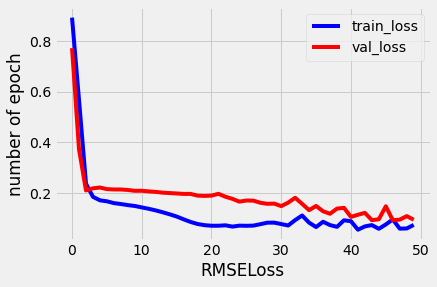

In [25]:
val_loss_ = np.array(val_loss).mean(-1)
train_loss_ = np.array(train_loss).mean(-1)
plt.plot(train_loss_, label='train_loss',c='b')
plt.plot(val_loss_, label='val_loss',c='r')
plt.xlabel(f'{criterion.__class__.__name__}')
plt.ylabel("number of epoch")
plt.legend()